<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [107]:
repo='https://github.com/avinashmane/colab.git'
import os,sys
if os.name=='nt':
    LIB= r'c:\m\lib'
    LOG= r'c:\m\social-media-automation'
    AUTH= r'c:\i\auth'
    sys.path.append("./lib")
else:
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    LIB='/content/drive/MyDrive/m/lib'
    LOG='/content/drive/MyDrive/m/lib'
    AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    if not os.path.exists('repo'):
      !git clone $repo repo
    sys.path.append('repo')
    sys.path.append("repo/lib")
sys.path.append(LIB)


ERROR! Session/line number was not unique in database. History logging moved to new session 3145


In [108]:
import yaml
cfg=yaml.load(u"""
repo:
    https://github.com/avinashmane/colab.git
packages: 
- chromium-chromedriver
modules:
- nerodia
- pygsheets
env:
    nt:
        LIB: c:/m/lib
        LOG: c:/m/social-media-automation
        AUTH: c:/i/auth
    posix:
        LIB: /content/drive/MyDrive/m/lib
        LOG: /content/drive/MyDrive/m/lib
        AUTH: /content/drive/MyDrive/m/auth
sheets:
    stravasync:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: Members
        range: A10:O
    StravaPromoLog:
        url: https://docs.google.com/spreadsheets/d/14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw/edit#gid=179675201
        tab: StravaPromoLog
        
""",Loader=yaml.Loader)
for x in cfg['env'][os.name]: 
    os.environ[x]=eval(x)

import importlib
import utils
importlib.reload(utils)
utils.setup_env(cfg['packages'],cfg['modules'])

'Environment setup'

## Code

In [135]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Strava=socialmediasite.Strava
SocialMediaSite=socialmediasite.SocialMediaSite


ERROR! Session/line number was not unique in database. History logging moved to new session 3149


In [110]:
"reach gsheet"

import gsheets
Gsheet=gsheets.Gsheet


In [111]:
df_mc=Gsheet(cfg['sheets']['stravasync']['url']).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')

# ssl=Gsheet('stravasync')
# df_mc

# Process
## Create headless

In [112]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-08-22 22:28:29:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [136]:
# %debug
# if os.name=='nt':
strava=Strava(b,authFile=f'{AUTH}/auth.yaml',cfgFile=f"{LIB}/cfg_strava.yaml")
strava.logGSheet = Gsheet(cfg['sheets']['StravaPromoLog']['url']).getSheetByTitle('StravaPromoLog')
strava.StravaMembers=df_mc.query('strava=="strava"').id.values

In [122]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.login("mileage_league_strava")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")


2022-08-22 22:30:21:INFO:Total number of cards on Dashboard | Strava: 19


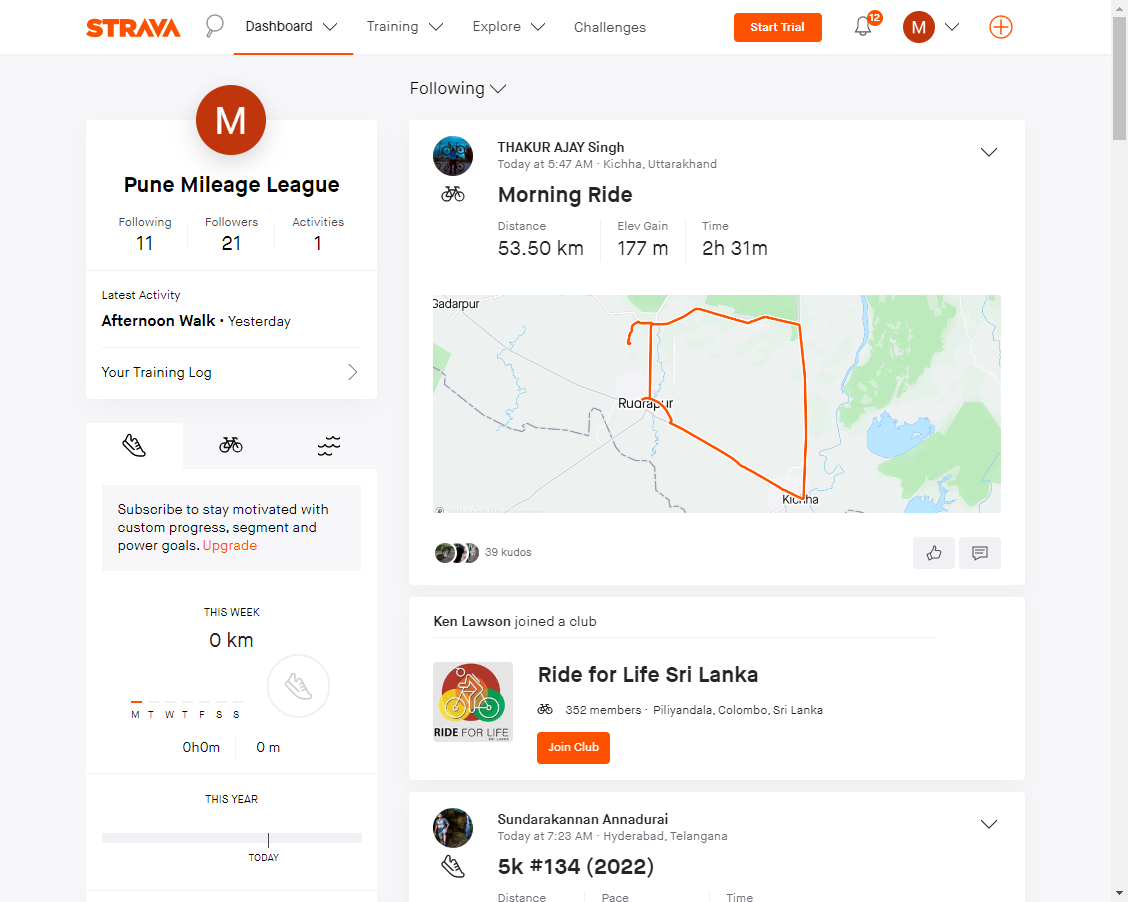

In [123]:
# strava.login("avinash")

Image(b.screenshot.png())

In [91]:
def getPageAths(sheetAths):
    for el in b.lis(class_name='row'): # b.uls(class_name='athlete-search')
        ath=[searchText]
        ath=ath+utils.getAttrsIfExists(el.div(class_name="follow-action"),['data_athlete_id','data_requires_approval'])
        ath=ath+el.text.split('\n')
        display(ath)
        sheetAths.append_table([ath])

In [116]:
# list athletes
sheetAths=Gsheet(cfg['sheets']['StravaPromoLog']['url']).getSheetByTitle('AthleteSearch')


def searchAthletes(searchText):
    searchUrl='https://www.strava.com/athletes/search?page={searchPage}&page_uses_modern_javascript=true&text={searchText}&utf8=%E2%9C%93'
    for searchPage in range(3,30):
        url=searchUrl.format(searchPage=searchPage,searchText=searchText)
        display(url)
        b.goto(url)
        getPageAths(sheetAths)
        
# searchAthletes('pimpri-chinchwad')        

## Give likes on users...top n activities

In [100]:
df_ids=pd.read_clipboard()

In [117]:
df_ids

,id
0,7040881
1,18809011
2,10338609
3,10190394
4,12683013
...,...
76,11136196
77,67603137
78,25421398
79,16158128


In [137]:
for i,d in df_ids.iterrows():
  strava.goto(f"https://www.strava.com/athletes/{d.id}?num_entries=5")
  # if i>0: break
  ret=strava.giveKudos()
  logging.info(f"Total number of cards on {d.id} '{strava.browser.title}': {ret}/{len(b.divs(class_name=re.compile('^Card')))}")
  # strava.giveKudos()

2022-08-22 23:00:24:INFO:Total number of cards on 7040881 'Strava Runner Profile | Shantanu Bedekar': {'count': 0}/1
2022-08-22 23:00:28:INFO:Total number of cards on 18809011 'Strava Cyclist Profile | Vikas Salunke': {'count': 0}/2
2022-08-22 23:00:31:INFO:Total number of cards on 10338609 'Strava Runner Profile | Kailas Padawale': {'count': 0}/0
2022-08-22 23:00:35:INFO:Total number of cards on 10190394 'Strava Runner Profile | Sumeet Mahajan': {'count': 0}/2
2022-08-22 23:00:39:INFO:Total number of cards on 12683013 'Strava Runner Profile | Krishna Garuda': {'count': 0}/0
2022-08-22 23:00:43:INFO:Total number of cards on 12180927 'Strava Runner Profile | Yogesh Wararkar': {'count': 0}/3
2022-08-22 23:00:47:INFO:Total number of cards on 95262713 'Strava Runner Profile | Suhas Pawar': {'count': 0}/13
2022-08-22 23:00:51:INFO:Total number of cards on 3923653 'Strava Runner Profile | Sachin Nagpure': {'count': 0}/1
2022-08-22 23:00:53:INFO:Total number of cards on 20000901 'Strava Runne

In [129]:
def giveKudosAth():
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")
for el in b.divs(class_name=re.compile('^EntryHeader')):
    display(strava.getPostData(el.parent()))

2022-08-22 22:34:26:INFO:Total number of cards on Strava Cyclist Profile | Vikas Salunke: 2


('Vikas Salunke',
 'https://www.strava.com/athletes/18809011',
 ' · Haveli, Maharashtra',
 'Morning Run',
 'https://www.strava.com/activities/7154936310',
 '42 kudos')

('Vikas Salunke',
 'https://www.strava.com/athletes/18809011',
 ' · Haveli, Maharashtra',
 'Evening Run',
 'https://www.strava.com/activities/7152509975',
 '39 kudos')

# Test like

In [ ]:
import unittest
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")

2022-08-15 22:46:49:INFO:Total number of cards on Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava: 20
2022-08-15 22:46:49:INFO:Total number of cards on Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava: 20


In [ ]:
for c_ in b.buttons(data_testid="kudos_button"):#text=re.compile('.*udos')): #'^EntryHeader')
    # print(dir(c_))
    actEl=c_.parent(class_name=re.compile('^EntryFooter')
                       ).parent()#.siblings(class_name=re.compile('^EntryHeader'))[0]
    # print(">",actEl.exists,actEl.tag_name,actEl.class_name,actEl.text[:9],)
    try:
        ath,athUrl=utils.getAttrsIfExists( actEl.link(data_testid="owners-name"),
                               ['text','href'])#,)
        loc=utils.getAttrsIfExists( actEl.div(data_testid="location"))
        act,actUrl=utils.getAttrsIfExists( actEl.link(data_testid="activity_name"),
                               ['text','href'])#,)
        kudoCount=utils.getAttrsIfExists( actEl.button(data_testid="kudos_count"))
        print(ath,athUrl,act,actUrl,kudoCount,loc)
    # ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","giveKudos",id,athId,name,actId,loc,]])    
    # logging.info(f"giveKudos: {i},{id},{athId} {actId} {hdr.text.split(',')[:1]}")
        # print(">>",len(c_.elements()),
        #       c_.text.replace("\n","/")[:80],
        #      )
        # utils.dumpChildren(actEl,attr=['tag_name','class_name','text','data_testid','id'])
    except TimeoutError:
        print('timeout')
    except Exception as e:
        print (f"something else {e!r}")

Vikash Agarwal https://www.strava.com/athletes/9233466 Evening Run https://www.strava.com/activities/7643109551 1 kudos  · Dubai, United Arab Emirates
Michelle Walker https://www.strava.com/athletes/6429484 Forgot My Water Bottles https://www.strava.com/activities/7642558930 19 kudos  · Warrick County, USA
Rick Simonson https://www.strava.com/athletes/3171614 Morning Run https://www.strava.com/activities/7642711821 8 kudos  · Ridgway, USA
Eric Ashe https://www.strava.com/athletes/8169908 Forgive us our trespasses https://www.strava.com/activities/7642774361 29 kudos  · Natick, USA
Swaminathan Srinivasan https://www.strava.com/athletes/16353981 Morning Walk https://www.strava.com/activities/7642481616 6 kudos  · Haveli, Maharashtra
Paul O'Neil https://www.strava.com/athletes/8476113 Upper Body Strength https://www.strava.com/activities/7642818271 7 kudos 
Vivek Chaudhari 🇮🇳 https://www.strava.com/athletes/24454841 Night Walk https://www.strava.com/activities/7642750613 12 kudos  · Havel

In [ ]:
bs=b.elements(tag_name='a',)
len(bs)

299

In [ ]:
"""
This is the "example" module.

The example module supplies one function, factorial().  For example,

>>> factorial(5)
120
"""

def factorial(n):
    """Return the factorial of n, an exact integer >= 0.

    >>> [factorial(n) for n in range(6)]
    [1, 1, 2, 6, 24, 120]
    >>> factorial(30)
    265252859812191058636308480000000
    >>> factorial(-1)
    Traceback (most recent call last):
        ...
    ValueError: n must be >= 0

    Factorials of floats are OK, but the float must be an exact integer:
    >>> factorial(30.1)
    Traceback (most recent call last):
        ...
    ValueError: n must be exact integer
    >>> factorial(30.0)
    265252859812191058636308480000000

    It must also not be ridiculously large:
    >>> factorial(1e100)
    Traceback (most recent call last):
        ...
    OverflowError: n too large
    """

    import math
    if not n >= 0:
        raise ValueError("n must be >= 0")
    if math.floor(n) != n:
        raise ValueError("n must be exact integer")
    if n+1 == n:  # catch a value like 1e300
        raise OverflowError("n too large")
    result = 1
    factor = 2
    while factor <= n:
        result *= factor
        factor += 1
    return result


import doctest
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=7)

In [ ]:
import unittest
importlib.reload(unittest)

class Avinash(unittest.TestCase):
    def setUp(self):
        print('setup')
    def tearDown(self):
        print('teardown')
        
    def test(self):
        # date = datetime.date(2020, 1, 1)
        self.assertEqual(2+3, 5)
        
    def test2(self):
        # date = datetime.date(2019, 12, 31)
        self.assertEqual(6/2, 3)
        
res = unittest.main(argv=[''], verbosity=0, exit=False)
# if we want our notebook to stop processing due to failures, we need a cell itself to fail
assert len(res.result.failures) == 0


setup
teardown
setup
teardown


----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


In [ ]:
importlib.reload(utils)
bs=b.buttons(data_testid="comment_button")
len(bs)

11

In [ ]:
# utils.dumpParents(bs[0])


for bs_ in bs:#bs0=bs[1]#.parent(class_name='EntryHeader--entry-header--lXRRn')
    postComment(bs_)
# utils.dumpTag(bs0)

    
# utils.dumpTag(bs0)
# utils.dumpChildren(bs0.parent(data_testid='kudos_comments_container'),"tag_name|class_name|text|title|data_testid".split('|'))

In [ ]:
ta.value='Nice!'

In [ ]:
dir(bs0)

In [ ]:
bs0=bs[0].parent(class_name='EntryHeader--entry-header--lXRRn')
for i in range(5):
    bs0=bs0.parent()
    utils.dumpTag(bs0)

In [ ]:
dir(bs[0].el)

In [ ]:
importlib.reload(utils)
len(bs)
utils.dumpChildren(bs0,attr=['tag_name','class_name','text','data_testid'])

In [ ]:
utils.dumpParents(bs[0])

# Test post

In [ ]:
## Comment on PCMC club
strava.goto("https://www.strava.com/clubs/196654/recent_activity")

In [ ]:
card=strava.getParent(x1[0],'div','^Card')

In [ ]:
card.text
[x.link().text for x in [card.div(class_name=re.compile("^MediaBody--media-body--"))]]

In [ ]:
KudosButtons=strava.browser.buttons(title=strava.giveKudosPattern)
for i,x in enumerate(KudosButtons):
  try:
    card=strava.getParent(x,'div','^Card')
    athId,ath=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
    actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
    for x in card.divs(class_name=re.compile("^MediaBody--media-body--")):
        name=x.link().text
        if x.exists:
            locEl=x.div(class_name=re.compile('^LocationAndTime--location--',)).wait_until(timeout=0.1, method=lambda _: True)
            loc=locEl
    # text=card.text.split(',')[:1]
    print(name,loc)
    # x.click() 
    try:
        x = int(re.findall(".*\/([0-9]*)",athId)[0])
        if x not in StravaMembers:
            x='nonMember'
    except:
        x='not valid'

    # self.browser.execute_script("arguments[0].click();", x)
    ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","Comments",x,athId,name,actId,loc,]])    
    logging.info(f"giveKudos: {i},{x} {athId} {actId} {name}")
  except Exception as e: 
    logging.warning(f"giveKudos: {i} error clicking {e!r}")


In [ ]:
b.link(href="#container-nav").click()

In [ ]:
b.button(title="Expand profile menu").hover()

In [ ]:
[(x.text,x.class_name,x.tag_name) for x in b.button(title="Expand profile menu").span().span()]

In [ ]:
# b.execute_script("window.scrollTo(0,0)")
# Image(b.screenshot.png())
re.findall(".*\/([0-9]*)","https://www.strava.com/athletes/27331750")[0]

In [ ]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

# DocTest


In [1]:
Browser()

Object `Browser()` not found.


In [2]:
import doctest

In [10]:
!python -m doctest lib/utils.py -v

Trying:
    setup_env([],['pandas'])
Expecting:
    'Environment setup'
ok
10 items had no tests:
    utils
    utils.cstr
    utils.dumpChildren
    utils.dumpParents
    utils.dumpTag
    utils.getAttrs
    utils.getAttrsIfExists
    utils.printAttrs
    utils.setLogger
    utils.shell
1 items passed all tests:
   1 tests in utils.setup_env
1 tests in 11 items.
1 passed and 0 failed.
Test passed.


# pydrive

In [39]:
# !pip install pydrive
import os
JSON_FILE=f'{AUTH}/indiathon-04d51b0b4caa.json'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

gauth = GoogleAuth()
scope = ["https://www.googleapis.com/auth/drive"]
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(JSON_FILE, scope)
drive = GoogleDrive(gauth)

In [40]:
??GoogleDriveFileList

Object `GoogleDriveFileList` not found.


In [41]:
file_list = drive.ListFile({'q': 'sharedWithMe'}).GetList()

In [42]:
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: PCMC strava sync, id: 1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY
title: Colab log, id: 14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw


In [43]:
import pandas as pd

In [44]:
# pd.DataFrame(file_list)
print(list(file_list))

[GoogleDriveFile({'kind': 'drive#file', 'id': '1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY', 'etag': '"MTY2MTE0MjEzOTgyNA"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY', 'alternateLink': 'https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit?usp=drivesdk', 'embedLink': 'https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/htmlembed?ouid=109556903566449714667', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/vnd.google-apps.spreadsheet', 'thumbnailLink': 'https://docs.google.com/feeds/vt?gd=true&id=1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY&v=200760&s=AMedNnoAAAAAYwMknvBuJ_a5l_wGbhw6WwjpYaLI2ewW&sz=s220', 'title': 'PCMC strava sync', 'mimeType': 'application/vnd.google-apps.spreadsheet', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'crea

# Standard Gdrive

In [63]:
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.oauth2 import service_account
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/drive.metadata.readonly']

class Drive:
    def __init__(self,JSON_FILE):
        """Shows basic usage of the Drive v3 API.
        Prints the names and ids of the first 10 files the user has access to.
        """
        creds = None
        # The file token.json stores the user's access and refresh tokens, and is
        # created automatically when the authorization flow completes for the first
        # time.

    #     if os.path.exists('token1.json'):
    #         creds = Credentials.from_authorized_user_file('token1.json', SCOPES)

        # If there are no (valid) credentials available, let the user log in.
        credentials = service_account.Credentials.from_service_account_file(
            JSON_FILE)

        self.creds = credentials.with_scopes(SCOPES)
        
        self.service = build('drive', 'v3', credentials=self.creds)
    

    def listFile(self,*kws):
        try:

            # Call the Drive v3 API
            results = self.service.files(*kws).list(
                pageSize=10, fields="nextPageToken, files(id, name, mimeType,webViewLink,createdTime,modifiedTime,size)").execute()  #id, name, 
            items = results.get('files', [])

            if not items:
                print('No files found.')
                return
            print('Files:')
            for item in items:
                print(u'{0} ({1})'.format(item['name'], item['id']))
            return([x for x in items])
        except HttpError as error:
            # TODO(developer) - Handle errors from drive API.
            print(f'An error occurred: {error}')

drv=Drive(JSON_FILE)
pd.DataFrame(drv.listFile()).style


Files:
PCMC strava sync (1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY)
Colab log (14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw)


,id,name,mimeType,webViewLink,createdTime,modifiedTime,size
0,1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY,PCMC strava sync,application/vnd.google-apps.spreadsheet,https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit?usp=drivesdk,2017-01-10T12:22:03.315Z,2022-08-22T04:57:18.517Z,6939103
1,14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw,Colab log,application/vnd.google-apps.spreadsheet,https://docs.google.com/spreadsheets/d/14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw/edit?usp=drivesdk,2022-08-19T05:30:38.716Z,2022-08-22T02:28:06.103Z,74987
